Todo

- Exportovat seznam seznamových sloupců, aby ho další sešit v pipelině načítal automaticky.

- Ještě mnoho sloupců seznamových, kvůli čárkám ", sro" nutno upravit při scrapování.

- Ukazují se exulantské filmy! Zároveň tam ale chceme nechat koprodukce. (Ten samý problém u herectva.)

- Premiéra do datetime.

- Rok výroby do dvou sloupců.

In [2]:
import pandas as pd

In [3]:
df = pd.read_json("filmy_raw.json")

In [4]:
df.columns.to_list()

['Film',
 'Země původu',
 'Copyright',
 'Rok výroby',
 'Premiéra',
 'Minutáž',
 'Režie',
 'Kategorie',
 'Žánr',
 'Typologie',
 'Originální název',
 'Český název',
 'Anglický název',
 'Souběžný název',
 'Pracovní název',
 'Pomocná režie',
 'Asistent režie',
 'Původní filmový námět',
 'Scénář',
 'Dramaturg',
 'Kamera',
 'Asistent kamery',
 'Architekt',
 'Návrhy kostýmů',
 'Masky',
 'Střih',
 'Zvuk',
 'Producent',
 'Vedoucí výroby',
 'Zástupce vedoucího výroby',
 'Odborný poradce',
 'Hudba',
 'Choreografie',
 'Lokace',
 'Distribuční slogan',
 'Výrobce',
 'S podporou',
 'Nositelé copyrightu',
 'Distribuce',
 'Délka',
 'Distribuční nosič',
 'Poměr stran',
 'Barva',
 'Zvukový systém/formát',
 'Verze',
 'Mluveno',
 'Podtitulky',
 'Úvodní/závěrečné titulky',
 'Anotace',
 'Obsah',
 'Technický scénář',
 'Výtvarník',
 'Animace',
 'Triky',
 'Postprodukce',
 'Návrhy titulků',
 'Pedagogické vedení',
 'Použitá hudba',
 'Studentský film',
 'Původní metráž',
 'Mezititulky',
 'Ocenění',
 'Vizuální efekt

In [5]:
def citlivy_orez(x):
    if isinstance(x, str):
        x = x.strip()
    if isinstance(x, list):
        try:
            x = [y.strip() for y in x]
        except:
            pass
    return(x)

In [6]:
def do_seznamu(polozka):
    try:
        if "," in polozka:
            polozka = str(polozka).split(",")
            polozka = [p.strip() for p in polozka]
    except:
        pass
    return(polozka)

In [7]:
df = df.apply(lambda x: citlivy_orez(x))

In [8]:
seznamove_sloupce = ["Žánr",
                     "Režie",
                     "Scénář",
                     "Mluveno",
                     "Barva",
                     "Zvukový systém/formát",
                     "Země původu",
                     "Úvodní/závěrečné titulky",
                     "Distribuční nosič",
                     "Země původu",
                     "Typologie",
                    "Předloha"]

In [9]:
for s in seznamove_sloupce:
    df[s] = df[s].apply(lambda x: do_seznamu(x))

In [10]:
df["Minutáž"] = df["Minutáž"].apply(lambda x: str(x).replace(" min",""))
df["Minutáž"] = pd.to_numeric(df["Minutáž"], errors="coerce")

In [11]:
def seznam_lokaci(lokace_hrube):
    lokace_ciste = []
    if lokace_hrube:
        lokace_hrube = lokace_hrube.split("),")
        for x in lokace_hrube:
            if "(" in x:
                x = x + ")"
            x = x.strip()
            x = x.replace("))",")")
            if x[0:2] == ", ":
                x = x[2:]
            if x != ")":
                lokace_ciste.append(x)
    return(lokace_ciste)

In [12]:
df["Lokace"] = df["Lokace"].apply(lambda x: seznam_lokaci(x))

In [13]:
def ratio(x):
    if x:
        x = x.replace("1:","")
        x = x.split(", ")
        x = [y.strip() for y in x]
        x = [y.replace(",",".") for y in x]
        x = [pd.to_numeric(y) for y in x]
        if len(x) == 1:
            x = x[0]
    return(x)

In [14]:
df["Poměr stran"] = df["Poměr stran"].apply(lambda x: ratio(x))

In [19]:
import re

In [17]:
def kill_whitespace(x):
    def seriously(y):
        y = re.sub("\s+", " ", y)
        return(y)
    if isinstance(x, list):
        x = [seriously(y) for y in x]
    if isinstance(x, str):
        x = seriously(x)
    return(x)

In [20]:
df["Ocenění"] = df["Ocenění"].apply(lambda x: kill_whitespace(x))

In [21]:
df = df.sort_values(by = "Copyright")

In [22]:
df.to_json("filmy.json", orient="records")

## Další experimenty

In [23]:
def premiera(x, jaka):
    try:
        if f"{jaka}premiéra" in x:
            x = x.split(f"{jaka}premiéra")[1]
            try:
                datum = re.search('.*?\d{4}', x).group().replace(f"{jaka}premiéra","").strip()
                # datum = pd.to_datetime(datum, errors="coerce", format = "%d. %m. %Y")
            except:
                datum = ""
            try:
                misto = re.search('\((.*?)\)', x).group().replace("(","").replace(")","").strip()
            except AttributeError:
                misto = ""
        else:
            datum = ""
            misto = ""
    except TypeError:
        datum = ""
        misto = ""
    return [datum, misto]

In [24]:
df["Slavnostní premiéra (datum)"] = df["Premiéra"].apply(lambda x: premiera(x, "slavnostní ")[0])
df["Slavnostní premiéra (místo)"] = df["Premiéra"].apply(lambda x: premiera(x, "slavnostní ")[1])
df["Distribuční premiéra (datum)"] = df["Premiéra"].apply(lambda x: premiera(x, "distribuční ")[0])
df["Distribuční premiéra (místo)"] = df["Premiéra"].apply(lambda x: premiera(x, "distribuční ")[1])
df["Festivalová premiéra (datum)"] = df["Premiéra"].apply(lambda x: premiera(x, "festivalová ")[0])
df["Festivalová premiéra (místo)"] = df["Premiéra"].apply(lambda x: premiera(x, "festivalová ")[1])
df["Zahraniční premiéra (datum)"] = df["Premiéra"].apply(lambda x: premiera(x, "zahraniční ")[0])
df["Zahraniční premiéra (místo)"] = df["Premiéra"].apply(lambda x: premiera(x, "zahraniční ")[1])
df["Premiéra bez upřesnění (datum)"] = df["Premiéra"].apply(lambda x: premiera(x, "")[0])

In [31]:
df["Slavnostní premiéra (datum)"] = pd.to_datetime(df["Slavnostní premiéra (datum)"], errors="coerce", format = "%d. %m. %Y")

In [34]:
df.groupby(pd.Grouper(key='Slavnostní premiéra (datum)', freq='M'))["Film"].nunique().nlargest(10)

Slavnostní premiéra (datum)
2020-08-31    12
2020-09-30    12
2021-09-30    10
2021-08-31     9
2011-03-31     8
2006-09-30     7
2018-10-31     7
2019-09-30     7
2019-10-31     7
2020-02-29     7
Name: Film, dtype: int64

<AxesSubplot:xlabel='Slavnostní premiéra (datum)'>

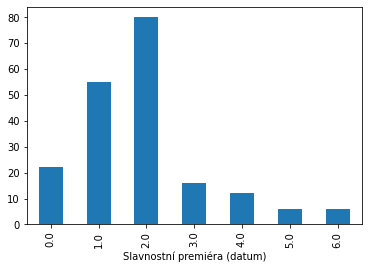

In [36]:
df[df["Slavnostní premiéra (datum)"] > "2013-04-12"].groupby(df['Slavnostní premiéra (datum)'].dt.weekday)["Film"].nunique().plot.bar()

<AxesSubplot:xlabel='Slavnostní premiéra (datum)'>

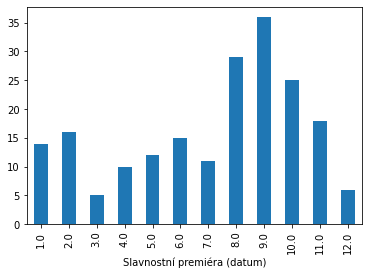

In [37]:
df[df["Slavnostní premiéra (datum)"] > "2013-04-12"].groupby(df['Slavnostní premiéra (datum)'].dt.month)["Film"].nunique().plot.bar()

In [32]:
df["Slavnostní premiéra (datum)"].drop_duplicates().to_list()

[NaT,
 Timestamp('1922-08-03 00:00:00'),
 Timestamp('1929-12-13 00:00:00'),
 Timestamp('1929-02-28 00:00:00'),
 Timestamp('1929-07-12 00:00:00'),
 Timestamp('1930-04-03 00:00:00'),
 Timestamp('1930-10-23 00:00:00'),
 Timestamp('1931-04-02 00:00:00'),
 Timestamp('1931-10-15 00:00:00'),
 Timestamp('1933-01-19 00:00:00'),
 Timestamp('1933-09-19 00:00:00'),
 Timestamp('1936-01-16 00:00:00'),
 Timestamp('1938-06-02 00:00:00'),
 Timestamp('1939-01-05 00:00:00'),
 Timestamp('1942-03-18 00:00:00'),
 Timestamp('1945-12-14 00:00:00'),
 Timestamp('1946-06-07 00:00:00'),
 Timestamp('1946-09-05 00:00:00'),
 Timestamp('1952-06-05 00:00:00'),
 Timestamp('1956-02-25 00:00:00'),
 Timestamp('1958-06-26 00:00:00'),
 Timestamp('1958-06-06 00:00:00'),
 Timestamp('1963-11-25 00:00:00'),
 Timestamp('1965-02-01 00:00:00'),
 Timestamp('1964-02-25 00:00:00'),
 Timestamp('1968-10-02 00:00:00'),
 Timestamp('1969-04-24 00:00:00'),
 Timestamp('1970-01-21 00:00:00'),
 Timestamp('1970-04-08 00:00:00'),
 Timestamp('19

In [22]:
df.sort_values(by='Slavnostní premiéra (datum)',ascending=False)

,Film,Země původu,Copyright,Rok výroby,Premiéra,Minutáž,Režie,Kategorie,Žánr,Typologie,...,Přístupnost,Slavnostní premiéra (datum),Slavnostní premiéra (místo),Distribuční premiéra (datum),Distribuční premiéra (místo),Festivalová premiéra (datum),Festivalová premiéra (místo),Zahraniční premiéra (datum),Zahraniční premiéra (místo),Premiéra bez upřesnění (datum)
4115,Ženská pomsta (402078),"[Česká republika, Slovensko]",2020,2019—2020,"slavnostní premiéra 9. 9. 2020 (kino Lucerna,...",88.0,Dušan Rapoš (12892),film,komedie,"[hraný, distribuční]",...,None,9. 9. 2020,"kino Lucerna, Praha",10. 9. 2020,,,,,,9. 9. 2020
3983,Hodinářův učeň (401938),"[Česká republika, Slovensko]",2019,2018—2019,slavnostní premiéra 9. 8. 2019 (multiplex Cin...,104.0,Jitka Rudolfová (8110),film,"[komedie, pohádka]","[hraný, distribuční]",...,None,9. 8. 2019,"multiplex Cinema City Velký Špalíček, Brno",15. 8. 2019,"Bratislava, Slovensko",,,12. 9. 2019,"Bratislava, Slovensko",9. 8. 2019
4235,Bathory (40761),"[Slovensko, Česká republika, Velká Británie, M...",2008,2006,slavnostní premiéra 9. 7. 2008 (multiplex Pal...,138.0,"[české verze Petr Sitár (3697), Marie Fronková...",film,"[historický, thriller]","[hraný, distribuční]",...,None,9. 7. 2008,"multiplex Palace Cinemas Slovanský dům, Praha",10. 7. 2008,,,,,,9. 7. 2008
323,Správce statku (23974),Česká republika,2004,2001—2002,"slavnostní premiéra 9. 6. 2004 (kino Lucerna,...",78.0,Martin Duba (529),film,rodinný,"[hraný, distribuční]",...,None,9. 6. 2004,"kino Lucerna, Praha",10. 6. 2004,,,,,,9. 6. 2004
237,Nazareth – Nekonečný rockový mejdan (184216),Česká republika,2013,2011—2012,slavnostní premiéra 9. 5. 2013 (Praha) ...,90.0,Miloslav Šmídmajer (1129),film,hudební,"[dokumentární, distribuční]",...,None,9. 5. 2013,Praha,,,,,,,9. 5. 2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,Poslušně hlásím (396291),Československo,1957,1957,předpremiéra 27. 12. 1957 (kino Sevastopol /1...,92.0,Karel Steklý (35894),film,"[komedie, satira, válečný]","[hraný, distribuční]",...,None,,,,,,,,,27. 12. 1957
1586,Případ ještě nekončí (396290),Československo,1957,1957,předpremiéra 6. 9. 1957 (kino Sevastopol /1 t...,80.0,Ladislav Rychman (7892),film,detektivní,"[hraný, distribuční]",...,None,,,,,,,,,6. 9. 1957
1585,Přítel lhář (396289),Československo,1957,1957,premiéra 21. 6. 1957 /nepřístupný mládeži/ (ki...,30.0,Jindřich Puš (83596),film,příběh,"[hraný, distribuční]",...,None,,,,,,,,,21. 6. 1957
1584,Ročník 21 (396288),"[Československo, Německá demokratická republika]",1957,1957,premiéra 21. 2. 1958 /nepřístupný mládeži/ (ki...,95.0,Václav Gajer (5065),film,drama,"[hraný, distribuční]",...,None,,,,,,,,,21. 2. 1958


In [23]:
df[df["Copyright"] == 1898].sort_values(by="Premiéra bez upřesnění (datum)")

,Film,Země původu,Copyright,Rok výroby,Premiéra,Minutáž,Režie,Kategorie,Žánr,Typologie,...,Přístupnost,Slavnostní premiéra (datum),Slavnostní premiéra (místo),Distribuční premiéra (datum),Distribuční premiéra (místo),Festivalová premiéra (datum),Festivalová premiéra (místo),Zahraniční premiéra (datum),Zahraniční premiéra (místo),Premiéra bez upřesnění (datum)
3767,Útok pražského dělostřelectva (401716),Rakousko-Uhersko,1898,1898,premiéra 07/1898 (Výstava architektury a inže...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,07/1898
412,Smích a pláč (395110),Rakousko-Uhersko,1898,1898,premiéra 07/1898 (Výstava architektury a inže...,1.0,Jan Kříženecký (127419),film,anekdota,"[hraný, distribuční]",...,None,,,,,,,,,07/1898
3764,Rychlovlak v Podbabí (401713),Rakousko-Uhersko,1898,1898,premiéra 07/1898 (Výstava architektury a inže...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,07/1898
3762,Přenesení kolébky Františka Palackého z Hodsla...,Rakousko-Uhersko,1898,1898,premiéra 07/1898 (Výstava architektury a inže...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,07/1898
3766,Svatojanská pouť v českoslovanské vesnici (401...,Rakousko-Uhersko,1898,1898,premiéra 19. 6. 1898 (Výstava architektury a ...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,19. 6. 1898
3763,Purkyňovo náměstí na Královských Vinohradech (...,Rakousko-Uhersko,1898,1898,premiéra 19. 6. 1898 (Výstava architektury a ...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,19. 6. 1898
3761,Polední výstřel na Mariánských hradbách (401709),Rakousko-Uhersko,1898,1898,premiéra 19. 6. 1898 (Výstava architektury a ...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,19. 6. 1898
3758,Defilování vojska o Božím těle na Královských ...,Rakousko-Uhersko,1898,1898,premiéra 19. 6. 1898 (Výstava architektury a ...,1.0,Jan Kříženecký (127419),film,reportáž,"[dokumentární, distribuční]",...,None,,,,,,,,,19. 6. 1898
413,Výstavní párkař a lepič plakátů (395111),Rakousko-Uhersko,1898,1898,premiéra 24. 7. 1898 (Výstava architektury a ...,1.0,Jan Kříženecký (127419),film,fraška,"[hraný, distribuční]",...,None,,,,,,,,,24. 7. 1898
3768,Voltýžování jízdního odboru Sokola pražského (...,Rakousko-Uhersko,1898,1898,premiéra 24. 7. 1898 (Výstava architektury a ...,1.0,Jan Kříženecký (127419),film,"[reportáž, sportovní]","[dokumentární, distribuční]",...,None,,,,,,,,,24. 7. 1898


In [24]:
df.groupby(df['Premiéra bez upřesnění (datum)'].dt.weekday)["Film"].nunique().nlargest(50)

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
df.groupby("Festivalová premiéra (místo)")["Film"].nunique().nlargest(50)

In [ ]:
df.groupby("Copyright")["Slavnostní premiéra (místo)"].nunique().plot()

In [ ]:
top_kina = df.groupby("Slavnostní premiéra (místo)")["Film"].nunique().nlargest(10).dropna().index.to_list()

In [ ]:
top_kina = [x for x in top_kina if x != ""]

In [ ]:
df[(df["Slavnostní premiéra (místo)"].isin(top_kina)) & (df["Copyright"] > 1989)].groupby(["Copyright","Slavnostní premiéra (místo)"])["Slavnostní premiéra (datum)"].nunique().unstack().plot()

In [ ]:
kino_mask = df['Slavnostní premiéra (místo)'].str.contains('kino')
multiplex_mask = df['Slavnostní premiéra (místo)'].str.contains('multiplex')

In [ ]:
import numpy as np

In [ ]:
df['group'] = pd.Series(
    np.where(kino_mask, 'kino', None) +
    np.where(multiplex_mask, 'multiplex', None)
)

In [ ]:
df.groupby(["Copyright", df["Slavnostní premiéra (místo)"].str.contains("kino|multiplex")])["Slavnostní premiéra (datum)"].nunique().plot()

In [ ]:
df["Lokace"].to_list()